In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import pickle

In [0]:
path_to_file = '20200525 - ls_tuplas_5_ASSISTANT_ONLY.pkl'

# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):

  with open(path, 'rb') as f:
    ls_tuplas = pickle.load(f)
  return zip(*ls_tuplas)

In [25]:

resp, expr = create_dataset(path_to_file, None)
print(expr[-1])
print(resp[-1])


<start> have a wonderful afternoon \. <end>
<start> carryout please \. ok \. will that be all for today ? yes \. thank you \. your pizza order is complete and your order will be ready for pick up in 25 minutes \. your receipt will be emailed to you \. thank you very much \. <end>


In [0]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [27]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]


# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))


10562 10562 2641 2641


In [0]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))


In [29]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])


Input Language; index to word mapping
1 ----> <start>
11 ----> i
73 ----> am
88 ----> sorry
23 ----> that
2680 ----> brussel
2681 ----> sprouts
21 ----> is
58 ----> out
27 ----> of
599 ----> stock
114 ----> as
146 ----> well
4 ----> ,
15 ----> would
5 ----> you
14 ----> like
10 ----> to
56 ----> pick
151 ----> something
37 ----> else
6 ----> ?
2 ----> <end>

Target Language; index to word mapping
7 ----> <start>
264 ----> thick
42 ----> please
1 ----> \.
21 ----> what
45 ----> are
9 ----> the
64 ----> toppinggs
5 ----> you
26 ----> want
3 ----> ?
103 ----> pineapple
2 ----> ,
535 ----> grilled
92 ----> chicken
2 ----> ,
100 ----> green
187 ----> pepper
10 ----> and
336 ----> olive
4 ----> i
57 ----> am
130 ----> sorry
13 ----> that
103 ----> pineapple
20 ----> is
76 ----> out
1 ----> \.
16 ----> would
5 ----> you
15 ----> like
12 ----> to
251 ----> substitute
19 ----> for
163 ----> something
55 ----> else
3 ----> ?
62 ----> how
71 ----> about
2281 ----> brussel
2282 ----> sprouts
3 ---

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 32
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 85
units = 300
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)


In [31]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([32, 217]), TensorShape([32, 289]))

In [0]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))


In [33]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))


Encoder output shape: (batch size, sequence length, units) (32, 217, 300)
Encoder Hidden state shape: (batch size, units) (32, 300)


In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [35]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))


Attention result shape: (batch size, units) (32, 300)
Attention weights shape: (batch_size, sequence_length, 1) (32, 217, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [37]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))


Decoder output shape: (batch_size, vocab size) (32, 4533)


In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [42]:
EPOCHS = 15
for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 1.2791
Epoch 1 Batch 100 Loss 0.9190
Epoch 1 Batch 200 Loss 0.7830
Epoch 1 Batch 300 Loss 0.6143
Epoch 1 Loss 0.7666
Time taken for 1 epoch 834.207998752594 sec

Epoch 2 Batch 0 Loss 0.6941
Epoch 2 Batch 100 Loss 0.6464
Epoch 2 Batch 200 Loss 0.7817
Epoch 2 Batch 300 Loss 0.6316
Epoch 2 Loss 0.6177
Time taken for 1 epoch 500.00929975509644 sec

Epoch 3 Batch 0 Loss 0.5303
Epoch 3 Batch 100 Loss 0.5113
Epoch 3 Batch 200 Loss 0.5264
Epoch 3 Batch 300 Loss 0.4399
Epoch 3 Loss 0.5643
Time taken for 1 epoch 494.54068756103516 sec

Epoch 4 Batch 0 Loss 0.5258
Epoch 4 Batch 100 Loss 0.5558
Epoch 4 Batch 200 Loss 0.4950
Epoch 4 Batch 300 Loss 0.5591
Epoch 4 Loss 0.5301
Time taken for 1 epoch 496.45320558547974 sec

Epoch 5 Batch 0 Loss 0.4506
Epoch 5 Batch 100 Loss 0.5169
Epoch 5 Batch 200 Loss 0.4486
Epoch 5 Batch 300 Loss 0.4009
Epoch 5 Loss 0.5079
Time taken for 1 epoch 497.22965240478516 sec

Epoch 6 Batch 0 Loss 0.5297
Epoch 6 Batch 100 Loss 0.4294
Epoch 6 Batch 200 L

In [0]:

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  #sentence = preprocess_sentence(sentence)
  #sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot


def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))


Input: <start> i would like to order a pizza from papa johns <end>
Predicted translation: i would like to order a pizza from pizza hut \. <end> 


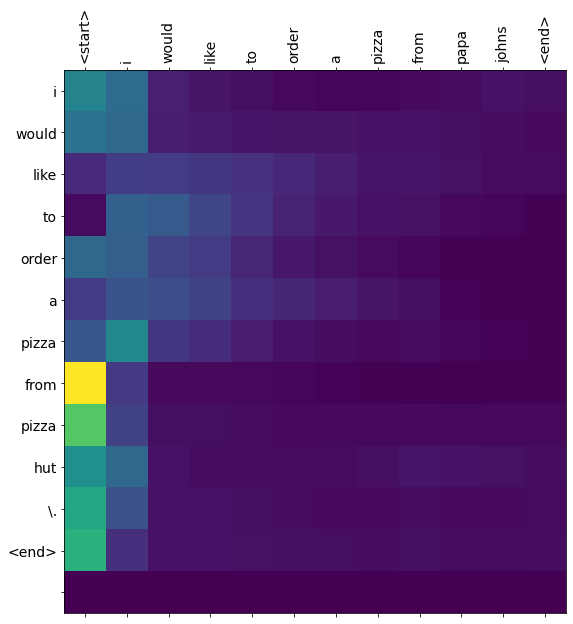

In [53]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

translate(u'<start> i would like to order a pizza from papa johns <end>')


Input: <start> hi i want to eat some pizza <end>
Predicted translation: i want to order a pizza from pizza hut <end> 


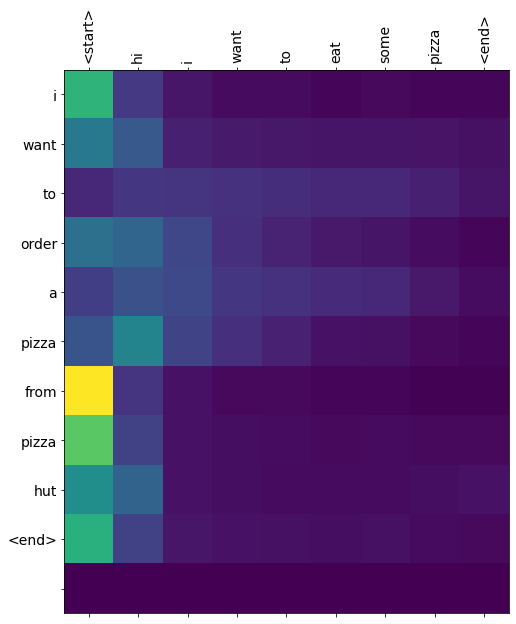

In [54]:
translate(u'<start> hi i want to eat some pizza <end>')


Input: <start> do you have any promotion <end>
Predicted translation: i would like to order a pizza from pizza hut \. <end> 


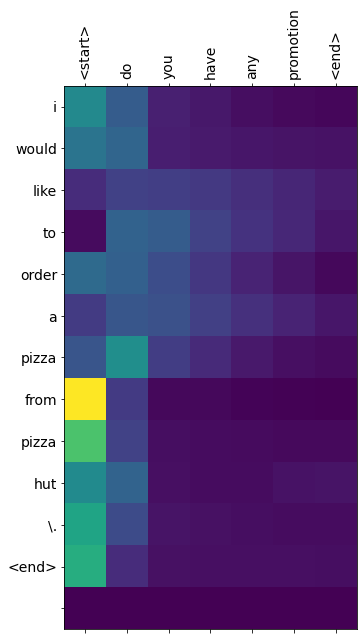

In [55]:
translate(u'<start> do you have any promotion <end>')

Input: <start> what is the cost of the extra ingredient <end>
Predicted translation: i would like to order a pizza from pizza hut \. <end> 


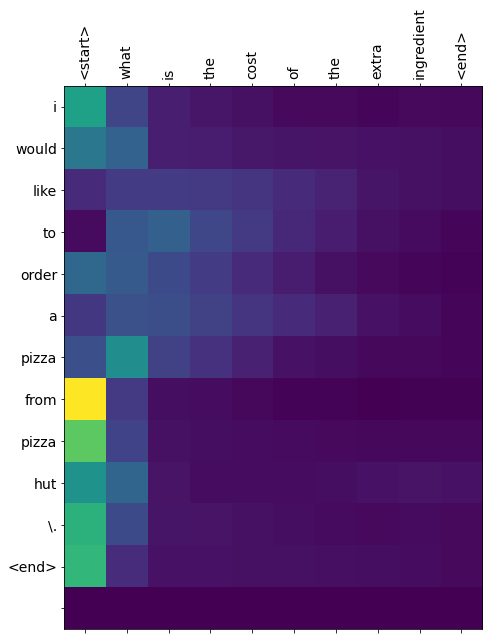

In [56]:
translate(u'<start> what is the cost of the extra ingredient <end>')

Input: <start> what is the delivery time <end>
Predicted translation: i would like to order a pizza from pizza hut \. <end> 


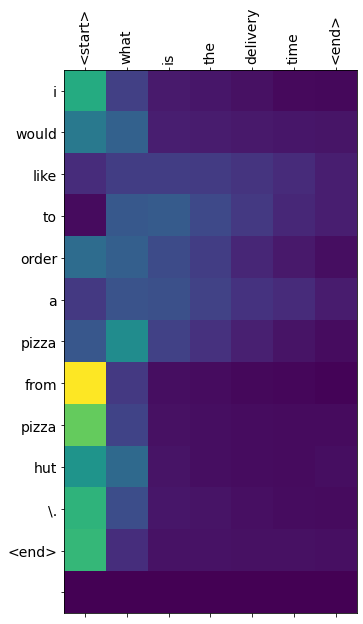

In [57]:
translate(u'<start> what is the delivery time <end>')